In [3]:
# Common imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10, 5)

# Альтернативные спобобы обучения

Стандартное обучение исходной модели (например, метод наименьших квадратов в линейной регрессии) может создавать описанныфе выше проблемы. Чтобы умееньшить вероятность их возникновения, применяют альтернативные способы обучения, такие как:
  * обучение с выбором подмножества фич (subset selection)
  * обучение с регуляризацией (shrinkage или regularization) 
  * обучение с уменьшением размерности фич (dimensionality reduction)

## Subset Selection

Идея проста:
   * создать множество моделей-кандидатов, содержащих толко часть фич
   * выбрать лучшего кандидата, оценив тестовую ошибку

### Best subset selection

```python
candidates = [M0]
for k in range(1, p + 1):
    pre_candidates = get_fit_models(n_features=k)  # все комбинации из p по k
    Mk = select_best_on_training(pre_candidates)
    candidates.append(Mk)
```

In [4]:
import os
import urllib
import shutil

def download_file(url, dir_path="datasets/"):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        
    file_name = os.path.split(url)[-1]
    file_path = os.path.join(dir_path, file_name)
    
    with urllib.request.urlopen(url) as response, open(file_path, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
        
    return file_path

In [8]:
# download_file("http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv")
adv_df = pd.read_csv('datasets/Advertising.csv', usecols=[1,2,3,4])
adv_df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


# Цель

Создать маркетинговый план на следующий год на основе данных из датасета, 
так чтобы продажи продукта были высокими

## Shrinkage (регуляризация)

In [13]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [14]:
X = adv_df[['TV', 'radio', 'newspaper']].values
y = adv_df.sales

In [17]:
lm = LinearRegression().fit(X, y)
print(lm.intercept_)
print(lm.coef_)

2.9388893694594103
[ 0.04576465  0.18853002 -0.00103749]


In [18]:
rg = Ridge().fit(X, y)
print(rg.intercept_)
print(rg.coef_)

2.9389674583301435
[ 0.04576464  0.1885251  -0.00103629]


In [21]:
rg.coef_ - lm.coef_

array([-0.00010323, -0.00506562,  0.00103749])

In [19]:
rg = Lasso().fit(X, y)
print(rg.intercept_)
print(rg.coef_)

3.040215583480377
[0.04566142 0.1834644  0.        ]


## Dimensionality reduction

Трансформирует $p$ фич в $M$ линейныйх комбинаций этих фич, так, что $M$ < $p$. Новые фичи $(Z_i)$ используются для построения
модели. Основная идея при трансыформации - объяснить новыми фичами как можно больший процент вариативности (variance)
исходных данных, при этом уменьшив размерность пространства.

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=X.shape[1]).fit(X)
for i in range(1, X.shape[1] + 1):
    print(f'n_components={i}, explaned variance {sum(pca.explained_variance_ratio_[:i]):.3f}')

n_components=1, explaned variance 0.914
n_components=2, explaned variance 0.978
n_components=3, explaned variance 1.000


In [24]:
new_adv_df = pd.DataFrame(PCA(n_components=1).fit_transform(X), columns=["f1"])
new_adv_df["Sales"] = adv_df.sales
new_adv_df.head(5)

,f1,Sales
0,83.788546,22.1
1,-102.138730,10.4
2,-128.992484,9.3
3,5.070972,18.5
4,34.059003,12.9


In [25]:
pca_lm = smf.ols('Sales ~ f1', new_adv_df).fit()
rss = np.sum(pca_lm.resid ** 2)
print("RSS:", rss)
print("R^2:", pca_lm.rsquared)

RSS: 2088.6304922990535
R^2: 0.6144409930964045


## PCA

Text(0, 0.5, 'feature 2')

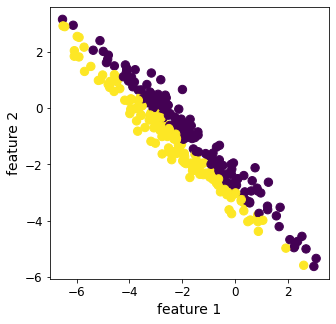

In [27]:
plt.rcParams['figure.figsize'] = 5, 5

rnd = np.random.RandomState(5)
X_ = rnd.normal(size=(300, 2))
X_blob = np.dot(X_, rnd.normal(size=(2, 2)))+ rnd.normal(size=2)
y = X_[:, 0] > 0
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y, s=70) # , linewidth=0
plt.xlabel('feature 1')
plt.ylabel('feature 2')

In [30]:
X_.shape

(300, 2)

In [32]:
X_blob.shape

(300, 2)

In [33]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_blob)
X_pca = pca.transform(X_blob)

Text(0, 0.5, 'second principal component')

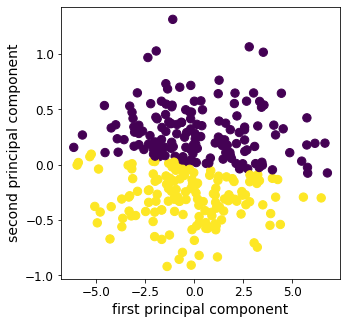

In [34]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=70) # linewidths=1
plt.xlabel("first principal component")
plt.ylabel("second principal component")

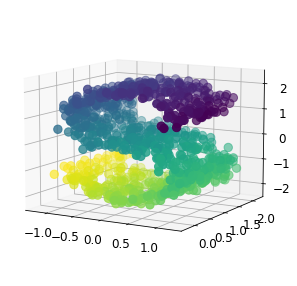

In [40]:
plt.rcParams['figure.figsize'] = 5, 5

from sklearn.datasets import make_s_curve
X, y = make_s_curve(n_samples=1000, noise=.1)

from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')

ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=y, s=70)
ax.view_init(10, -60)

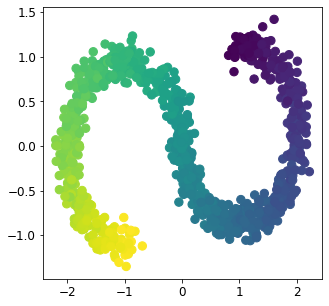

In [48]:
X_pca = PCA(n_components=2).fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=70)